In [1]:
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
dataset = pd.read_csv('仿生沖頭.csv', engine='python')
dataset = dataset.fillna(dataset.bfill())
date_time = pd.to_datetime(dataset.pop('Date Time'), format='%Y.%m.%d')
print(dataset.head())

column_indices = {name: i for i, name in enumerate(dataset.columns)}

       data
0  1.579287
1  2.199132
2  2.803541
3  2.743335
4  1.812266


In [3]:
n = len(dataset)
train_df = dataset[0:int(n * 0.7)]
val_df = dataset[int(n * 0.7):int(n * 0.9)]
test_df = dataset[int(n * 0.9):]


In [4]:
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
num_features = dataset.shape[1]

In [5]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [6]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels


WindowGenerator.split_window = split_window

In [7]:
def plot(self, model=None, plot_col='data', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n + 1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')
    plt.show()


WindowGenerator.plot = plot

In [8]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    '''
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32, )
    '''
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32, )
    ds = ds.map(self.split_window)
    return ds


WindowGenerator.make_dataset = make_dataset

In [9]:
@property
def train(self):
    return self.make_dataset(self.train_df)


@property
def val(self):
    return self.make_dataset(self.val_df)


@property
def test(self):
    return self.make_dataset(self.test_df)


@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

In [10]:
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['data'])

wide_window = WindowGenerator(
    input_width=160, label_width=160, shift=1,
    label_columns=['data'])

In [11]:
MAX_EPOCHS = 80


def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                         patience=patience,
                         mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [12]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['data'])

In [13]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

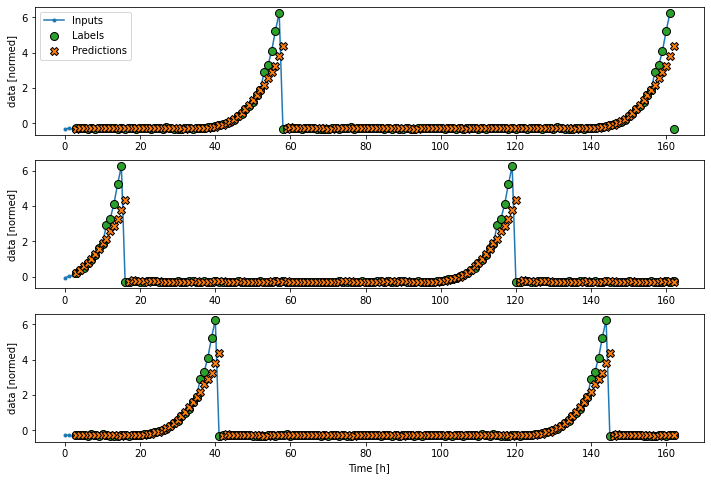

In [14]:
history = compile_and_fit(conv_model, conv_window, 8)

IPython.display.clear_output()
LABEL_WIDTH = 160
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['data'])

wide_conv_window.plot(conv_model)

In [15]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

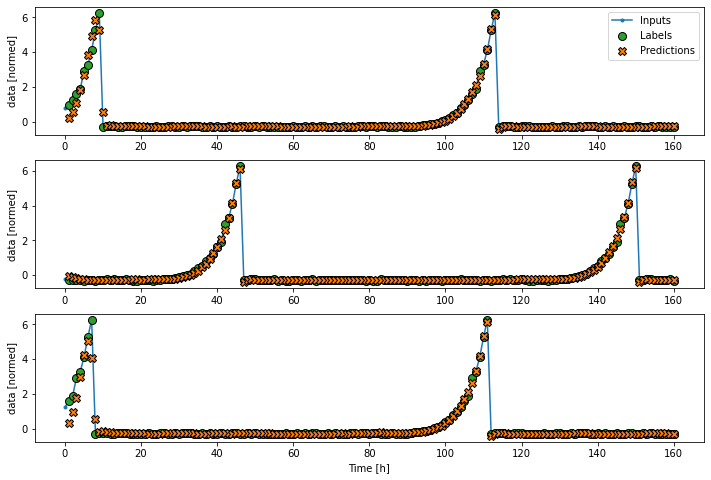

In [16]:
history = compile_and_fit(lstm_model, wide_window, 8)
IPython.display.clear_output()
wide_window.plot(lstm_model)

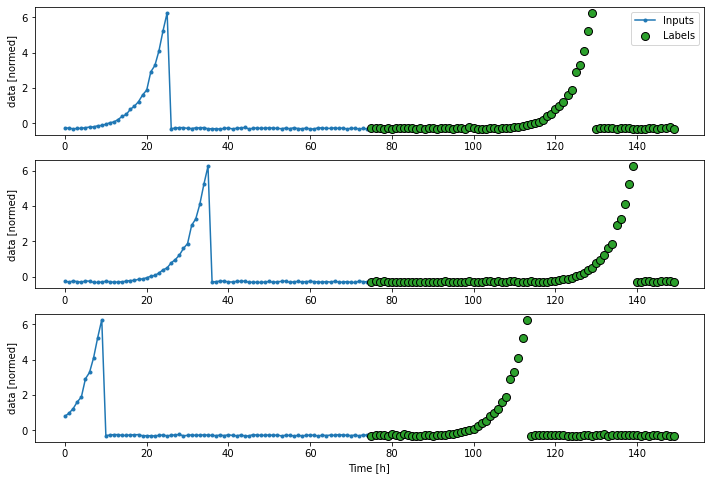

Total window size: 150
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74]
Label indices: [ 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149]
Label column name(s): None

In [17]:
OUT_STEPS = 75
multi_window = WindowGenerator(input_width=75,
                label_width=OUT_STEPS,
                shift=OUT_STEPS)

multi_window.plot()
multi_window

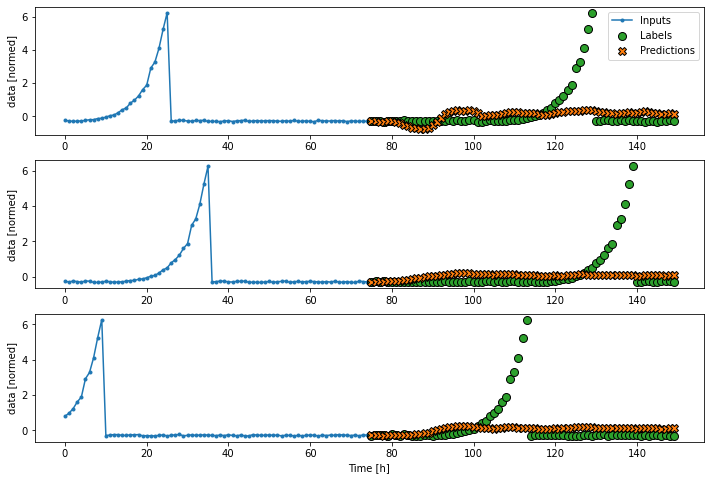

In [18]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window, 20)

IPython.display.clear_output()
multi_window.plot(multi_conv_model)

In [19]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=False)),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window, 20)

Epoch 1/80
7/7 [==============================] - 2s 80ms/step - loss: 1.1157 - mean_absolute_error: 0.4999
Epoch 2/80
7/7 [==============================] - 1s 96ms/step - loss: 0.9224 - mean_absolute_error: 0.4857
Epoch 3/80
7/7 [==============================] - 1s 115ms/step - loss: 0.7918 - mean_absolute_error: 0.4610
Epoch 4/80
7/7 [==============================] - 1s 108ms/step - loss: 0.7150 - mean_absolute_error: 0.4291
Epoch 5/80
7/7 [==============================] - 1s 109ms/step - loss: 0.6698 - mean_absolute_error: 0.3977
Epoch 6/80
7/7 [==============================] - 1s 95ms/step - loss: 0.6281 - mean_absolute_error: 0.3736
Epoch 7/80
7/7 [==============================] - 1s 82ms/step - loss: 0.5887 - mean_absolute_error: 0.3514
Epoch 8/80
7/7 [==============================] - 1s 90ms/step - loss: 0.5696 - mean_absolute_error: 0.3390
Epoch 9/80
7/7 [==============================] - 1s 93ms/step - loss: 0.5517 - mean_absolute_error: 0.3231
Epoch 10/80
7/7 [========

7/7 [==============================] - 1s 85ms/step - loss: 0.2445 - mean_absolute_error: 0.1693
Epoch 77/80
7/7 [==============================] - 1s 83ms/step - loss: 0.2470 - mean_absolute_error: 0.1725
Epoch 78/80
7/7 [==============================] - 1s 83ms/step - loss: 0.2510 - mean_absolute_error: 0.1786
Epoch 79/80
7/7 [==============================] - 1s 83ms/step - loss: 0.2582 - mean_absolute_error: 0.1716
Epoch 80/80
7/7 [==============================] - 1s 83ms/step - loss: 0.2351 - mean_absolute_error: 0.1723


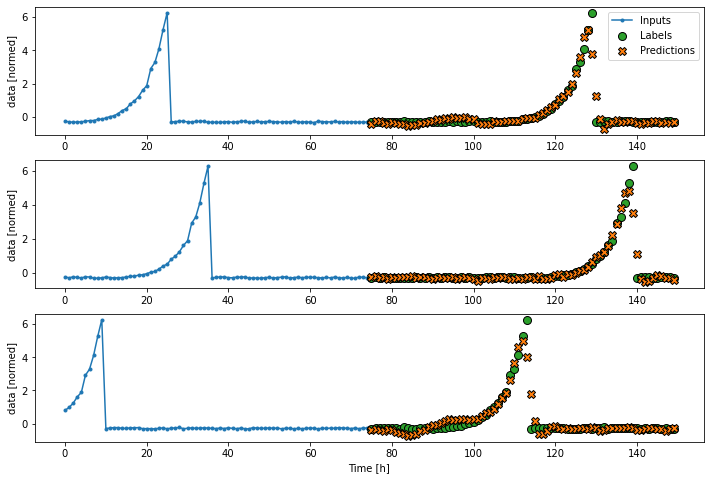

In [20]:
multi_window.plot(multi_lstm_model)

In [21]:
import json
model_json = multi_lstm_model.to_json()
with open("model_trained.json", "w") as json_file:
    json.dump(model_json, json_file)
multi_lstm_model.save("model_trained.h5")
print('完成')

完成


In [22]:
from tensorflow.keras.models import model_from_json
with open('model_trained.json','r') as f:
    model_json = json.load(f)
loaded_model = model_from_json(model_json)
loaded_model.load_weights('model_trained.h5')

testdata = pd.read_csv('mototest.csv', engine='python')
testdata = (testdata - 8.314611) / 22.435781

[-3.7437475e-01 -2.8464180e-01 -2.7151656e-01 -3.3608711e-01
 -2.5347871e-01 -2.0083673e-01 -3.8073456e-01 -4.8585644e-01
 -4.5165777e-01 -4.1932154e-01 -4.7976401e-01 -3.9684862e-01
 -3.5197002e-01 -2.7268991e-01 -1.8389209e-01 -1.0714109e-01
 -1.0710550e-01 -1.4962931e-01 -1.1470826e-01 -1.8646814e-01
 -1.3644245e-01 -3.5723716e-01 -2.4847853e-01 -3.2470033e-01
 -4.4531894e-01 -4.0053701e-01 -3.4878474e-01 -3.9415163e-01
 -4.0571427e-01 -4.8307729e-01 -3.2363310e-01 -1.6926172e-01
 -1.1123671e-01 -2.0528100e-01 -2.5755048e-01 -1.7358446e-03
 -7.1145348e-02  2.5258219e-02  7.2200648e-02  1.8531778e-01
  4.2618018e-01  5.4352158e-01  7.6598603e-01  9.2715412e-01
  1.1831698e+00  1.5174685e+00  1.8406196e+00  2.6684051e+00
  3.6859944e+00  4.5818515e+00  5.0452247e+00  4.0788827e+00
  1.5508074e+00 -1.1573730e-01 -5.7350063e-01 -3.6267373e-01
 -2.0406574e-01 -1.7732516e-01 -1.7576939e-01 -2.7117112e-01
 -2.2613227e-01 -2.8848365e-01 -3.2459360e-01 -2.7755892e-01
 -2.6571381e-01 -2.22716

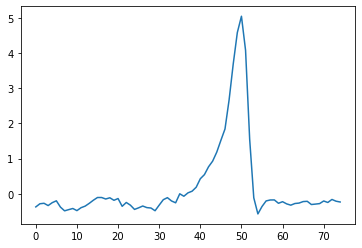

In [23]:
testds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=testdata,
        targets=None,
        sequence_length=75,
        sequence_stride=1,
        shuffle=False,
        batch_size=1, )
predictions = loaded_model.predict(testds)
print(predictions[0, :, 0])
plt.plot(predictions[0, :, 0])
plt.show()

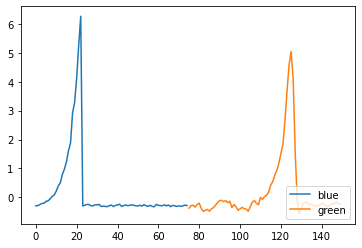

In [24]:
plt.plot(range(0,75,1),testdata)
plt.plot(range(75,150,1),predictions[0, :, 0])
plt.legend(["blue", "green"], loc ="lower right") 
plt.show()